In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
gen_df = pd.read_csv('GEN-sarc-notsarc.csv')
hyp_df = pd.read_csv('HYP-sarc-notsarc.csv')
rq_df = pd.read_csv('RQ-sarc-notsarc.csv')

In [ ]:
gen_df.head()

,class,id,text
0,notsarc,1,"If that's true, then Freedom of Speech is doom..."
1,notsarc,2,Neener neener - is it time to go in from the p...
2,notsarc,3,"Just like the plastic gun fear, the armour pie..."
3,notsarc,4,So geology is a religion because we weren't he...
4,notsarc,5,Well done Monty. Mark that up as your first ev...


In [ ]:
# Clean text data
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()                  # Convert to lowercase
    return text

In [ ]:
# Apply text cleaning
gen_df['cleaned_text'] = gen_df['text'].apply(clean_text)
hyp_df['cleaned_text'] = hyp_df['text'].apply(clean_text)
rq_df['cleaned_text'] = rq_df['text'].apply(clean_text)

In [ ]:
combined_df = pd.concat([gen_df, hyp_df, rq_df], ignore_index=True)

In [ ]:
label_encoder = LabelEncoder()
combined_df['label'] = label_encoder.fit_transform(combined_df['class'])

In [ ]:
# Tokenize and pad sequences
max_len = 100
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_df['cleaned_text'])

In [ ]:
sequences = tokenizer.texts_to_sequences(combined_df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, combined_df['label'], test_size=0.2, random_state=42)


**LSTM Model**

In [ ]:
# LSTM Model
# lstm_model = Sequential()
# lstm_model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_len))
# lstm_model.add(LSTM(64, return_sequences=True))
# lstm_model.add(LSTM(64))
# lstm_model.add(Dense(1, activation='sigmoid'))

# lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# lstm_history = lstm_model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


**CNN model**

In [ ]:
# CNN Model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_len))
cnn_model.add(Conv1D(64, 3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6028 - loss: 0.6604 - val_accuracy: 0.6944 - val_loss: 0.5637
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7792 - loss: 0.4763 - val_accuracy: 0.7386 - val_loss: 0.5327
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8690 - loss: 0.3352 - val_accuracy: 0.7034 - val_loss: 0.5922
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9341 - loss: 0.2058 - val_accuracy: 0.7236 - val_loss: 0.6593
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9768 - loss: 0.1014 - val_accuracy: 0.7162 - val_loss: 0.7902


In [ ]:
# Plotting function for model history
def plot_model_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [ ]:
# plot_model_history(lstm_history, 'LSTM')

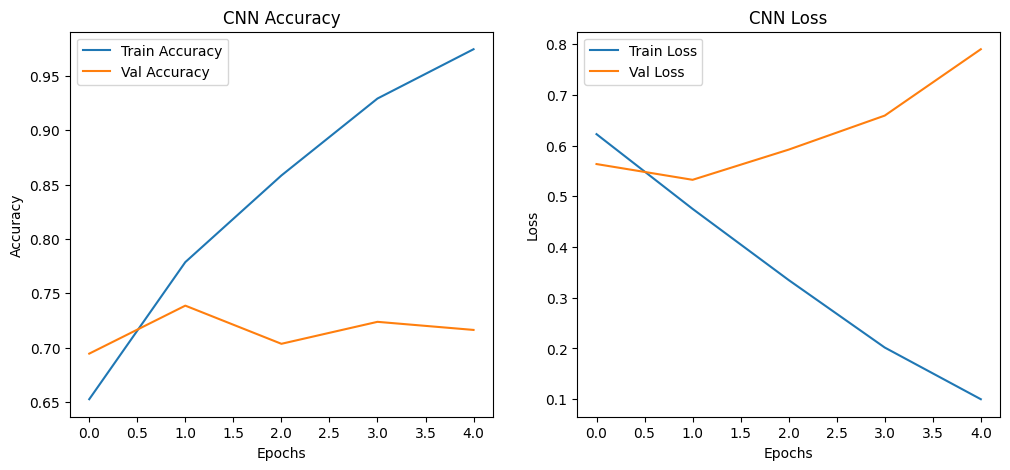

In [ ]:
plot_model_history(cnn_history, 'CNN')

In [ ]:
# Evaluate model
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'{model_name} Performance:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}')

In [ ]:
# Evaluate LSTM
# evaluate_model(lstm_model, X_test, y_test, 'LSTM')

In [ ]:
evaluate_model(cnn_model, X_test, y_test, 'CNN')

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
CNN Performance:
Accuracy: 0.7161874334398296
Precision: 0.6997055937193327
Recall: 0.7585106382978724
F1-score: 0.7279224093925473


In [ ]:
# Function to preprocess the input text
def preprocess_input(text, tokenizer, max_len):
    text = clean_text(text)  # Clean the input
    sequence = tokenizer.texts_to_sequences([text])  # Tokenize the input
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')  # Pad the input
    return padded_sequence

In [ ]:
# Predict with CNN
cnn_prediction = cnn_model.predict(padded_input)


# CNN interpretation
if cnn_prediction >= 0.5:
    print(f"The comment is likely sarcastic (CNN).")
else:
    print(f"The comment is likely NOT sarcastic (CNN).")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The comment is likely NOT sarcastic (CNN).


In [ ]:
!pip install gensim

In [ ]:
# -*- coding: utf-8 -*-
"""Twitter Sentiment Analysis

This script performs sentiment analysis on Twitter data using various machine learning models.
"""

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score
from wordcloud import WordCloud
from tqdm import tqdm
import gensim

# Install necessary libraries if not already installed
!pip install wordcloud xgboost gensim tqdm

# Download necessary NLTK data
nltk.download('stopwords', quiet=True)

# Load the data
# Note: Make sure you've uploaded the CSV files to your Colab environment
train = pd.read_csv('/content/train_tweet.csv')
test = pd.read_csv('/content/test_tweets.csv')

print(train.shape)
print(test.shape)

# Display first few rows of train and test data
print(train.head())
print(test.head())

# Check for null values
print(train.isnull().any())
print(test.isnull().any())



(31962, 3)
(17197, 2)
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation
      id                                              tweet
0  31963  #studiolife #aislife #requires #passion #dedic...
1  31964   @user #white #supremacists want everyone to s...
2  31965  safe ways to heal your #acne!!    #altwaystohe...
3  31966  is the hp and the cursed child book up for res...
4  31967    3rd #bihday to my amazing, hilarious #nephew...
id       False
label    False
tweet    False
dtype: bool
id       False
tweet    False
dtype: bool


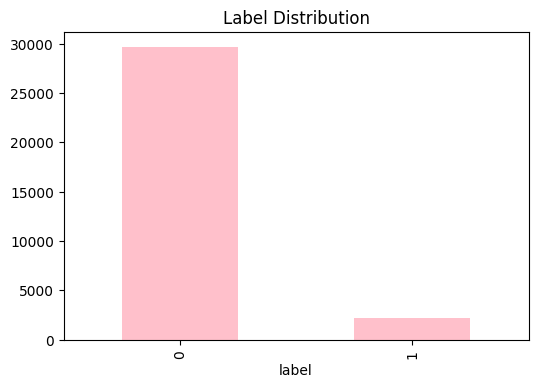

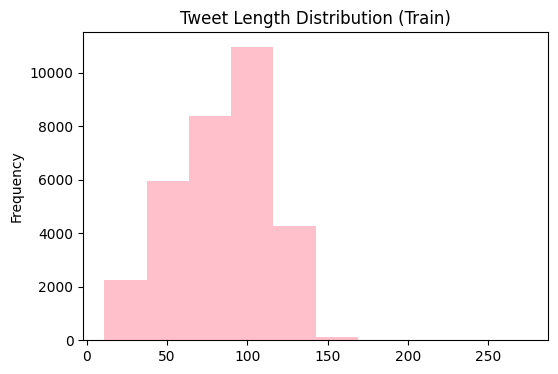

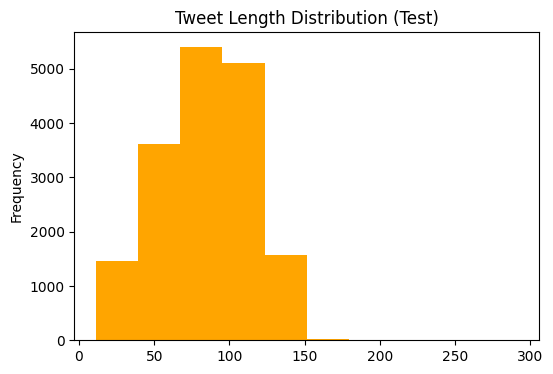

In [ ]:
# Visualize label distribution
train['label'].value_counts().plot.bar(color='pink', figsize=(6, 4))
plt.title('Label Distribution')
plt.show()

# Visualize tweet length distribution
train['tweet'].str.len().plot.hist(color='pink', figsize=(6, 4))
plt.title('Tweet Length Distribution (Train)')
plt.show()

test['tweet'].str.len().plot.hist(color='orange', figsize=(6, 4))
plt.title('Tweet Length Distribution (Test)')
plt.show()

In [ ]:

# Add length column (ensure it's numeric)
train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

# Analyze label statistics
print(train.groupby('label').describe())

            id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25   
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                    len                                                        
           max    count       mean        std   min   25%   50%    75%    max  
label                                                                          
0      31962.0  29720.0  84.328634  29.566484  11.0  62.0  88.0  107.0  274.0  
1      31961.0   2242.0  90.187779  27.375502  12.0  69.0  96.0  111.0  152.0  


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


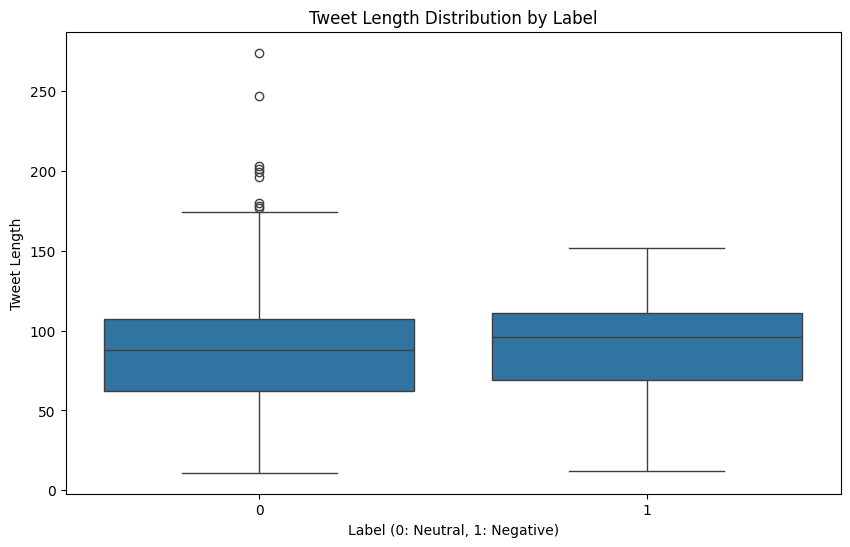

In [ ]:
# Visualize length vs label
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='len', data=train)
plt.title('Tweet Length Distribution by Label')
plt.xlabel('Label (0: Neutral, 1: Negative)')
plt.ylabel('Tweet Length')
plt.show()

Average tweet length by label:
label
0    84.328634
1    90.187779
Name: len, dtype: float64


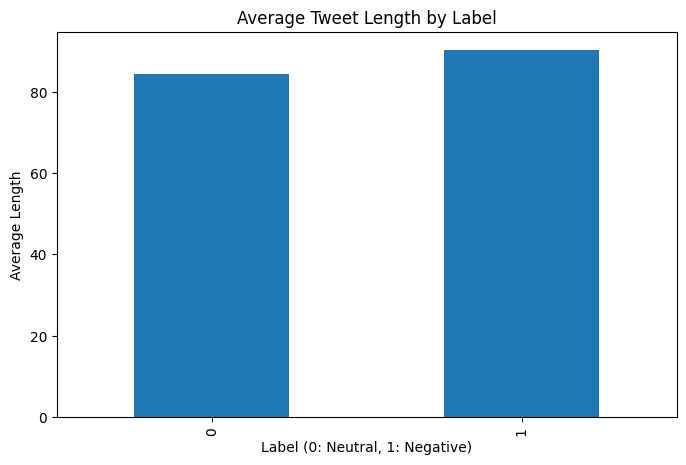

<ipython-input-98-a7d7bba42c07>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  len_label_dist = train.groupby('len_bin')['label'].mean()


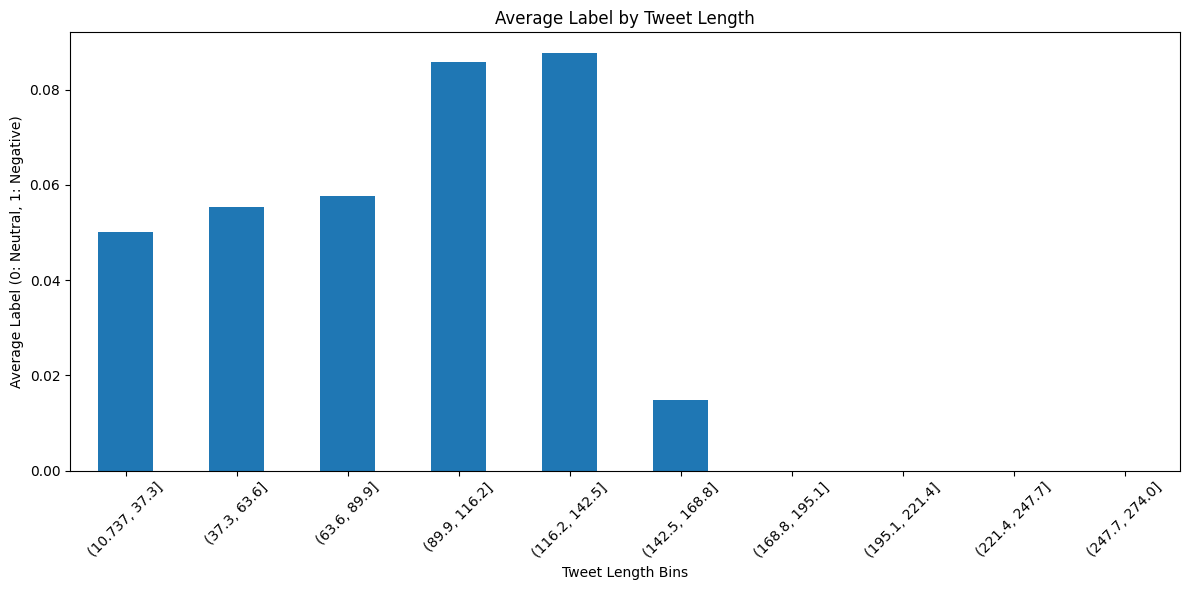

In [ ]:
# Calculate average length for each label
avg_len = train.groupby('label')['len'].mean()
print("Average tweet length by label:")
print(avg_len)

# Visualize average length by label
avg_len.plot(kind='bar', figsize=(8, 5))
plt.title('Average Tweet Length by Label')
plt.xlabel('Label (0: Neutral, 1: Negative)')
plt.ylabel('Average Length')
plt.show()

# Create length bins and visualize
train['len_bin'] = pd.cut(train['len'], bins=10)
len_label_dist = train.groupby('len_bin')['label'].mean()
len_label_dist.plot(kind='bar', figsize=(12, 6))
plt.title('Average Label by Tweet Length')
plt.xlabel('Tweet Length Bins')
plt.ylabel('Average Label (0: Neutral, 1: Negative)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

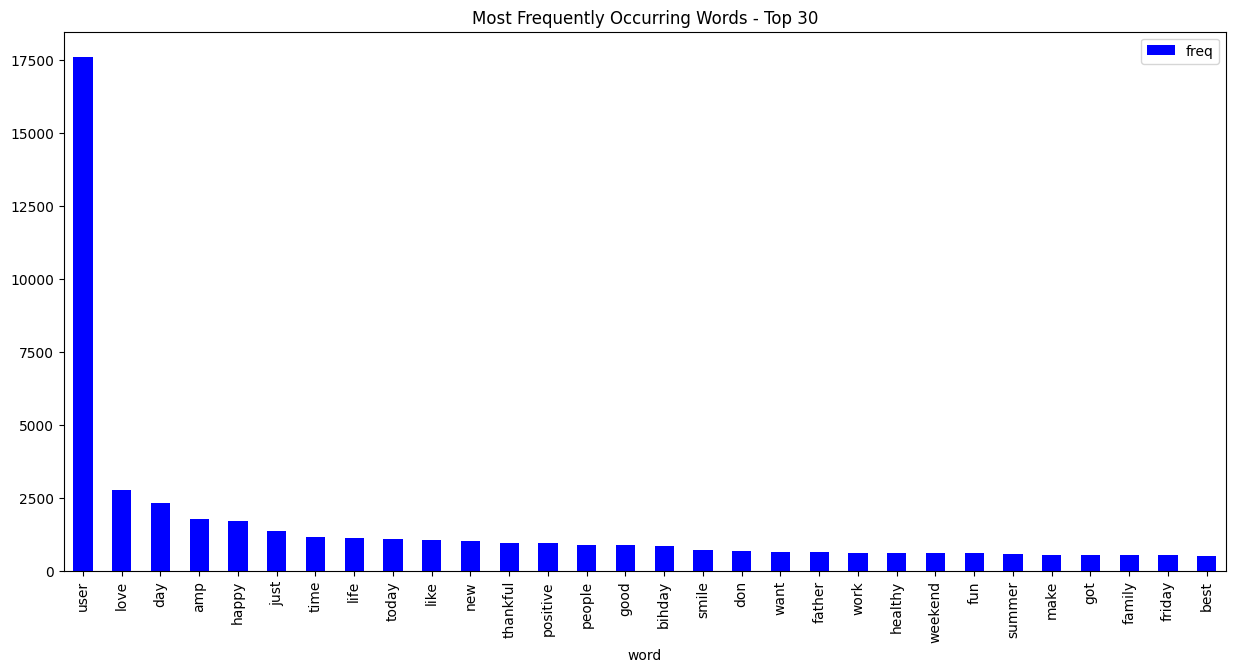

In [ ]:
# Word frequency analysis
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(train.tweet)

sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color='blue')
plt.title("Most Frequently Occurring Words - Top 30")
plt.show()

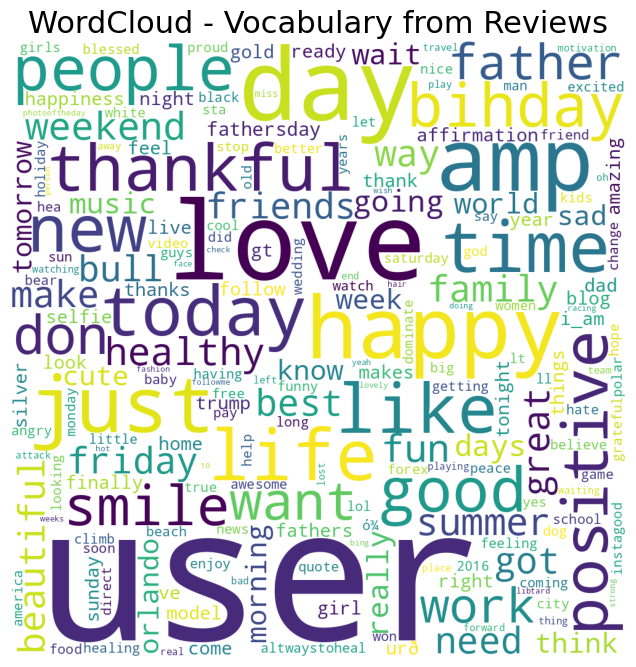

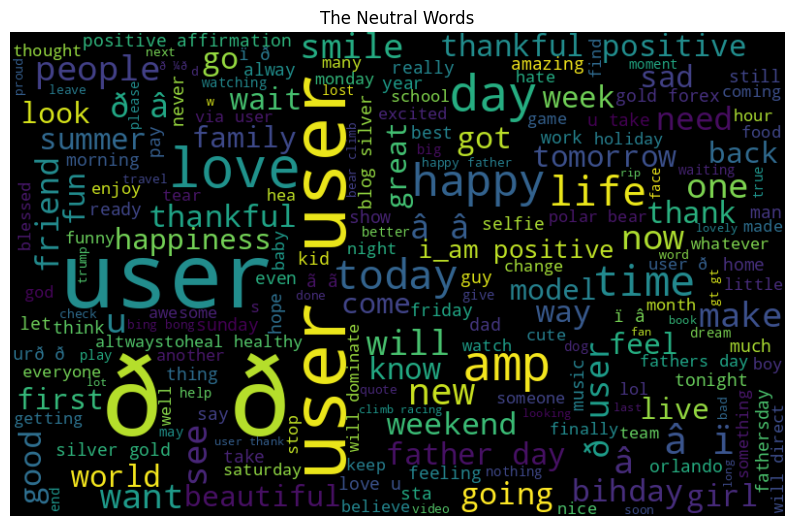

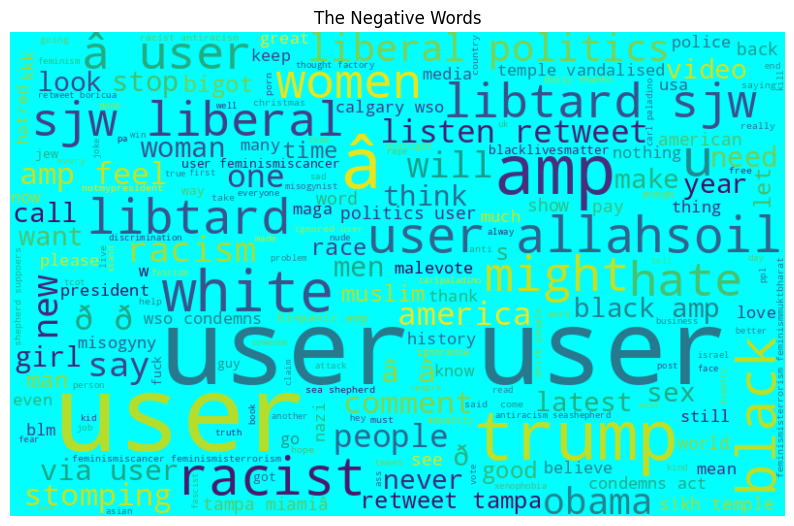

In [ ]:

# Generate word cloud
wordcloud = WordCloud(background_color='white', width=1000, height=1000).generate_from_frequencies(dict(words_freq))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize=22)
plt.axis('off')
plt.show()

# Generate word clouds for neutral and negative words
normal_words = ' '.join([text for text in train['tweet'][train['label'] == 0]])
negative_words = ' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=0, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

wordcloud = WordCloud(background_color='cyan', width=800, height=500, random_state=0, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()


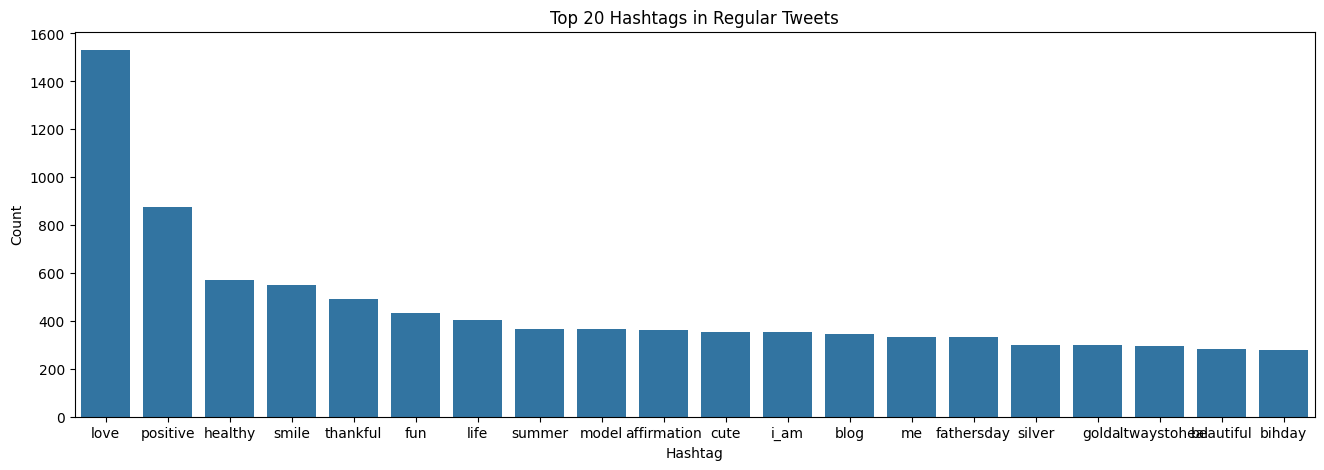

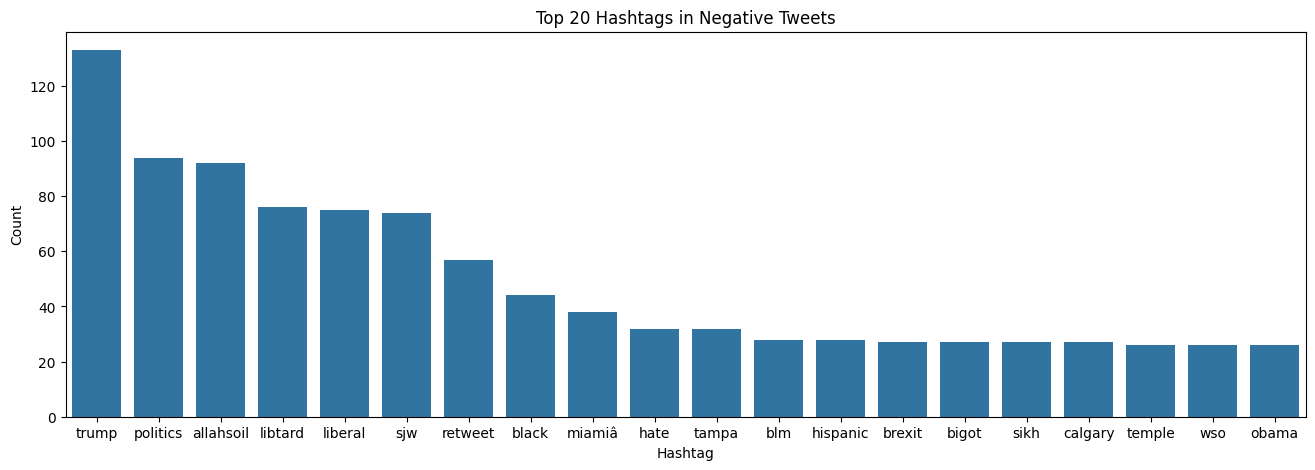

(6109992, 8411580)

In [ ]:

# Hashtag analysis
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

HT_regular = hashtag_extract(train['tweet'][train['label'] == 0])
HT_negative = hashtag_extract(train['tweet'][train['label'] == 1])

HT_regular = sum(HT_regular, [])
HT_negative = sum(HT_negative, [])

freq_regular = nltk.FreqDist(HT_regular)
d_regular = pd.DataFrame({'Hashtag': list(freq_regular.keys()),
                          'Count': list(freq_regular.values())})

d_regular = d_regular.nlargest(columns="Count", n=20)
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=d_regular, x="Hashtag", y="Count")
ax.set(ylabel='Count')
plt.title('Top 20 Hashtags in Regular Tweets')
plt.show()

freq_negative = nltk.FreqDist(HT_negative)
d_negative = pd.DataFrame({'Hashtag': list(freq_negative.keys()),
                           'Count': list(freq_negative.values())})

d_negative = d_negative.nlargest(columns="Count", n=20)
plt.figure(figsize=(16, 5))
ax = sns.barplot(data=d_negative, x="Hashtag", y="Count")
ax.set(ylabel='Count')
plt.title('Top 20 Hashtags in Negative Tweets')
plt.show()

# Word2Vec model
tokenized_tweet = train['tweet'].apply(lambda x: x.split())

model_w2v = gensim.models.Word2Vec(
    tokenized_tweet,
    vector_size=200,
    window=5,
    min_count=2,
    sg=1,
    hs=0,
    negative=10,
    workers=2,
    seed=34
)

model_w2v.train(tokenized_tweet, total_examples=len(train['tweet']), epochs=20)


In [ ]:

# Print similar words
print("Words similar to 'dinner':", model_w2v.wv.most_similar(positive="dinner"))
print("Words similar to 'cancer':", model_w2v.wv.most_similar(positive="cancer"))
print("Words similar to 'apple':", model_w2v.wv.most_similar(positive="apple"))
print("Words opposite to 'hate':", model_w2v.wv.most_similar(negative="hate"))


Words similar to 'dinner': [('spaghetti', 0.6382330060005188), ('#wanderlust', 0.6051642894744873), ('enroute', 0.6014275550842285), ('#boardgames', 0.5949339866638184), ('7!', 0.591825008392334), ('podium', 0.589532732963562), ('sister!!', 0.5859469771385193), ('#prosecco', 0.585170328617096), ('#teamlh', 0.5754149556159973), ('bay.', 0.5743644833564758)]
Words similar to 'cancer': [('behavior.', 0.7129223346710205), ('spewing', 0.7069569826126099), ('champion,', 0.7012413144111633), ('ways.', 0.696800172328949), ('politicizing', 0.6950448155403137), ('inflict', 0.694662868976593), ('tolerance', 0.693486213684082), ('ownership', 0.6921455264091492), ('roots', 0.6912393569946289), ('rights,', 0.6911011934280396)]
Words similar to 'apple': [('mytraining', 0.6952357292175293), ('"mytraining"', 0.6930590271949768), ('training"', 0.6720443367958069), ('app,', 0.6348116397857666), ('ta', 0.6027299165725708), ('"my', 0.580879271030426), ('ios', 0.5693953633308411), ('humans.', 0.562359631061

In [ ]:

# Text preprocessing
def preprocess_text(text):
    # Convert to lowercase and remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text.lower())

    # Tokenize
    words = text.split()

    # Remove stopwords and stem
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words if word not in set(stopwords.words('english'))]

    return ' '.join(words)

train_corpus = [preprocess_text(tweet) for tweet in tqdm(train['tweet'], desc="Preprocessing train data")]
test_corpus = [preprocess_text(tweet) for tweet in tqdm(test['tweet'], desc="Preprocessing test data")]

# Create bag of words
cv = CountVectorizer(max_features=2500)
x = cv.fit_transform(train_corpus).toarray()
y = train['label'].values

x_test = cv.transform(test_corpus).toarray()

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=42)

# Standardize the features
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)


Preprocessing test data: 100%|██████████| 17197/17197 [00:37<00:00, 458.40it/s]


In [ ]:

# Define a function to train and evaluate models
def train_and_evaluate(model, model_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)

    print(f"\n{model_name} Results:")
    print("Training Accuracy:", model.score(x_train, y_train))
    print("Validation Accuracy:", model.score(x_valid, y_valid))
    print("F1 score:", f1_score(y_valid, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_valid, y_pred))

# Train and evaluate different models
models = [
    (RandomForestClassifier(), "Random Forest"),
    (LogisticRegression(), "Logistic Regression"),
    (DecisionTreeClassifier(), "Decision Tree"),
    (SVC(), "Support Vector Machine"),
    (XGBClassifier(), "XGBoost")
]

for model, name in models:
    train_and_evaluate(model, name)

print("\nAnalysis complete!")


Random Forest Results:
Training Accuracy: 0.999123941429227
Validation Accuracy: 0.9516956576148167
F1 score: 0.6085192697768763
Confusion Matrix:
[[7305  127]
 [ 259  300]]

Logistic Regression Results:
Training Accuracy: 0.9848984189228651
Validation Accuracy: 0.943186084344888
F1 score: 0.598939929328622
Confusion Matrix:
[[7198  234]
 [ 220  339]]

Decision Tree Results:
Training Accuracy: 0.9991656585040257
Validation Accuracy: 0.9325491177574772
F1 score: 0.5365434221840069
Confusion Matrix:
[[7140  292]
 [ 247  312]]

Support Vector Machine Results:
Training Accuracy: 0.978181969880272
Validation Accuracy: 0.9521962207483419
F1 score: 0.49868766404199477
Confusion Matrix:
[[7419   13]
 [ 369  190]]

XGBoost Results:
Training Accuracy: 0.9608693838388053
Validation Accuracy: 0.9550744587661119
F1 score: 0.5751479289940828
Confusion Matrix:
[[7389   43]
 [ 316  243]]

Analysis complete!


In [ ]:
#model 2 DL -neg overfit


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Ensure necessary NLTK data is downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Improved preprocessing function
def preprocess_text(text):
    # Keep some punctuation
    text = re.sub(r'[^a-zA-Z.!?]', ' ', text.lower())
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords, but keep negative words
    stop_words = set(stopwords.words('english')) - {'no', 'not', 'nor', 'neither'}
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Load and preprocess data
train = pd.read_csv('train_tweet.csv')
test = pd.read_csv('test_tweets.csv')

train['processed_tweet'] = train['tweet'].apply(preprocess_text)
test['processed_tweet'] = test['tweet'].apply(preprocess_text)

# Tokenize and pad sequences
max_words = 15000  # Increased vocabulary size
max_len = 50

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train['processed_tweet'])

X_train_seq = tokenizer.texts_to_sequences(train['processed_tweet'])
X_test_seq = tokenizer.texts_to_sequences(test['processed_tweet'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Create improved deep learning model
def create_dl_model(vocab_size, embedding_dim, max_length):
    input_layer = Input(shape=(max_length,))
    embedding_layer = Embedding(vocab_size, embedding_dim)(input_layer)
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
    pooling_layer = GlobalMaxPooling1D()(lstm_layer)
    dropout_layer = Dropout(0.5)(pooling_layer)
    dense_layer = Dense(32, activation='relu')(dropout_layer)
    output_layer = Dense(1, activation='sigmoid')(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train deep learning model with cross-validation
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200  # Increased embedding dimension

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dl_models = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train_pad, train['label']), 1):
    print(f"Training fold {fold}")
    X_train_fold, X_val_fold = X_train_pad[train_index], X_train_pad[val_index]
    y_train_fold, y_val_fold = train['label'].iloc[train_index], train['label'].iloc[val_index]

    dl_model = create_dl_model(vocab_size, embedding_dim, max_len)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = dl_model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=1,
        batch_size=64,
        callbacks=[early_stopping]
    )
    dl_models.append(dl_model)

# Extract features from DL models
dl_features_train = np.mean([model.predict(X_train_pad) for model in dl_models], axis=0)
dl_features_test = np.mean([model.predict(X_test_pad) for model in dl_models], axis=0)

# Prepare traditional ML features
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
tfidf_train = tfidf.fit_transform(train['processed_tweet']).toarray()
tfidf_test = tfidf.transform(test['processed_tweet']).toarray()

# Combine features
X_combined_train = np.hstack((tfidf_train, dl_features_train))
X_combined_test = np.hstack((tfidf_test, dl_features_test))

# Scale features
scaler = StandardScaler()
X_combined_train_scaled = scaler.fit_transform(X_combined_train)
X_combined_test_scaled = scaler.transform(X_combined_test)

# Train ML models
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
lr_model = LogisticRegression(C=1.0, random_state=42)
xgb_model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)

# Create and train ensemble
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('xgb', xgb_model)
    ],
    voting='soft',
    weights=[1, 1, 2]  # Giving more weight to XGBoost
)

ensemble.fit(X_combined_train_scaled, train['label'])

# Make predictions
train_predictions = ensemble.predict(X_combined_train_scaled)
test_predictions = ensemble.predict(X_combined_test_scaled)

# Evaluate model
train_accuracy = accuracy_score(train['label'], train_predictions)
train_f1 = f1_score(train['label'], train_predictions)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")
print("\nClassification Report:")
print(classification_report(train['label'], train_predictions))

# Function to predict sentiment for new tweets
def predict_sentiment(tweet): #///////////////////// TO BE PLACED Above ///////////////////////
    processed_tweet = preprocess_text(tweet)
    seq = tokenizer.texts_to_sequences([processed_tweet])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    dl_features = np.mean([model.predict(padded) for model in dl_models], axis=0)
    tfidf_features = tfidf.transform([processed_tweet]).toarray()

    combined_features = np.hstack((tfidf_features, dl_features))
    scaled_features = scaler.transform(combined_features)

    prediction = ensemble.predict_proba(scaled_features)[0]
    confidence = TextBlob(tweet).sentiment.polarity
    if  confidence > 0.5:
      sentiment = "Positive"
    elif confidence == 0.5:
      sentiment = "Mild Positive"
    elif confidence < 0.5 and confidence > -0.4:
      sentiment = "Neutral"
    elif confidence == -0.5:
      sentiment = "Mild Negative"
    else:
      sentiment =  "Negative"

    return sentiment, confidence

# Example usage
new_tweet = "I absolutely love this new product! It's amazing!"
sentiment, confidence = predict_sentiment(new_tweet)
print(f"\nThe sentiment of '{new_tweet}' is: {sentiment} (Confidence: {confidence:.2f})")

# Additional test cases
test_tweets = [
    "This is the worst experience I've ever had.",
    "The product is okay, but could be better.",
    "I'm feeling neutral about this.",
    "Absolutely fantastic service!",
    "Not sure if I like it or not."
]

for tweet in test_tweets:
    sentiment, confidence = predict_sentiment(tweet)
    print(f"\nTweet: {tweet}")
    print(f"Predicted sentiment: {sentiment} (Confidence: {confidence:.2f})")

Training fold 1
400/400 ━━━━━━━━━━━━━━━━━━━━ 94s 224ms/step - accuracy: 0.9296 - loss: 0.2778 - val_accuracy: 0.9585 - val_loss: 0.1202
Training fold 2
400/400 ━━━━━━━━━━━━━━━━━━━━ 94s 223ms/step - accuracy: 0.9314 - loss: 0.2772 - val_accuracy: 0.9571 - val_loss: 0.1250
Training fold 3
400/400 ━━━━━━━━━━━━━━━━━━━━ 95s 228ms/step - accuracy: 0.9213 - loss: 0.2929 - val_accuracy: 0.9537 - val_loss: 0.1279
Training fold 4
400/400 ━━━━━━━━━━━━━━━━━━━━ 94s 226ms/step - accuracy: 0.9190 - loss: 0.2956 - val_accuracy: 0.9592 - val_loss: 0.1246
Training fold 5
400/400 ━━━━━━━━━━━━━━━━━━━━ 96s 229ms/step - accuracy: 0.9099 - loss: 0.2975 - val_accuracy: 0.9560 - val_loss: 0.1330
999/999 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step
999/999 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step
999/999 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step
999/999 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step
999/999 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step
538/538 ━━━━━━━━━━━

In [ ]:
# Custom input
test_tweets = [
    "This is the worst experience I've ever had.",
    "Talk about worlds best phone , haha.",
    "I'm feeling neutral about this.",
    "Absolutely fantastic service!",
    "Not sure if I like it or not."
]


for tweet in test_tweets:

    sentiment, confidence = predict_sentiment(tweet)
    print(f"\nTweet: {tweet}")
    print(f"Predicted sentiment: {sentiment} (Confidence: {confidence:.2f})")
    # Preprocess the input
    padded_input = preprocess_input(tweet, tokenizer, max_len)
    cnn_prediction = cnn_model.predict(padded_input)
    # CNN interpretation
    if cnn_prediction >= 0.5:
        print(f"The comment is likely sarcastic (CNN).")
    else:
        print(f"The comment is likely NOT sarcastic (CNN).")
# Preprocess the input


NameError: name 'predict_sentiment' is not defined